In [18]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
'''
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
'''

In [19]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [20]:
annotation_path = './additional_custom/2007_train.txt'
log_dir = 'logs/000/'
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [27]:
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

In [ ]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [29]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [ ]:
model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/yolo.h5') # make sure you know what you freeze

In [ ]:
#model.load_weights('trained_weights_final.h5')
model.load_weights('./model_data/yolo.h5')

In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss={
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})

In [ ]:
batch_size = 1
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=1,
        initial_epoch=0,
        callbacks=[logging, checkpoint])

In [ ]:
model.summary()

In [17]:
import tensorflow_model_optimization as tfmot 
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 8
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = 2501
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs


#'''
#Defining pruning parameters

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

#'''

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(yolo_model, **pruning_params)

#model_for_pruning.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model_for_pruning.compile()

#model_for_pruning.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

model_for_pruning.summary()
#'''

Instructions for updating:
Please use `layer.add_weight` method instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv2d_1 (P (None, None, None, 3 1730        input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_batch_norma (None, None, None, 3 129         prune_low_magnitude_conv2d_1[0][0
__________________________________________________________________________________________________
prune_low_magnitude_leaky_re_lu (None,

In [21]:
p_checkpoints_path = 'yolo_pruned'
p_checkpoint = ModelCheckpoint(filepath=p_checkpoints_path + "{epoch:02d}.h5",save_weights_only=True,save_best_only=True,
                               monitor='loss',
                            verbose=True)

In [23]:
import tensorflow 

log_dir = '.\pruning_logs'
p_callbacks_n = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch = 100000000, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch'),
  tfmot.sparsity.keras.PruningSummaries(
    log_dir, update_freq='epoch'
  ), p_checkpoint
]

In [25]:
model_for_pruning.compile(optimizer=Adam(lr=1e-3))

In [30]:
batch_size = 1
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model_for_pruning.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=1,
        initial_epoch=0,
        callbacks=[logging, p_callbacks_n])

Train on 2251 samples, val on 250 samples, with batch size 1.


AttributeError: 'list' object has no attribute 'set_model'

In [24]:
model_for_pruning.compile(optimizer=Adam(lr=1e-3), loss={
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})

ValueError: Unknown entries in loss dictionary: ['yolo_loss']. Only expected following keys: ['prune_low_magnitude_conv2d_59', 'prune_low_magnitude_conv2d_67', 'prune_low_magnitude_conv2d_75']

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [14]:
from tensorflow.keras.models import load_model

In [15]:
model_path='./model_data/yolo.h5'
yolo_model = load_model(model_path, compile=False)

In [16]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
from PIL import Image, ImageFont, ImageDraw
import cv2
from timeit import default_timer as timer

import numpy as np
from tensorflow.keras import backend as K
import os
import colorsys

import matplotlib.pyplot as plt

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from yolo3.utils import letterbox_image

In [2]:
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

In [3]:
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes
    
    def detect_image(self,image):
        im = cv2.imread(image)
        image = Image.open(image)
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')


        print('Image_data shape is',image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        #np.save('image_terminal.npy', image_data)
        print(image_data)
        print('printing image size 1 & 2', image.size[1], image.size[0])
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        #print('out_boxes',out_boxes)

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))

        font2 = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 0.5

        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

            #cv2.rectangle(im, (left, top), (right, bottom), color=(0, 255, 0), thickness=2)
            #cv2.putText(im, label, (left, top), font2, fontScale, color=(255,255,0), thickness=2)
        #cv2.imshow('im', im)
        #if cv2.waitKey(0) & 0xFF == ord('q'):
            #cv2.destroyAllWindows()
        
        

        end = timer()
        print(end - start)
        return im

    def close_session(self):
        self.sess.close()

model_data/yolo.h5 model, anchors, and classes loaded.
Image_data shape is (416, 416, 3)
[[[[0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   ...
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]]

  [[0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   ...
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]]

  [[0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   ...
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]]

  ...

  [[0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   ...
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]
   [0.5019608 0.5019608 0.5019608]]

  [[0.5019608 0.5019608 0.50

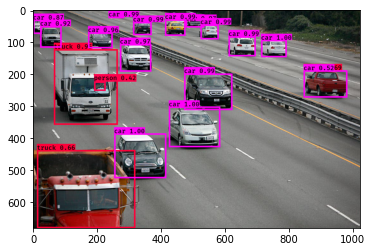

In [12]:
obj = YOLO()
#b = obj.detect_image('./additional_custom/street.jpg')
c =obj.detect_image('./additional_custom/random_car.jpg')
plt.imshow(c)